# Some Tests for a Wikipedia Retriever

In [47]:
# Settings

verbose = True # additional output for testing and troubleshooting

articles_considered = 10 # number of wikipedia articles retrieved. The reasoning_model will pick relevant articles from these. Higher numbers add overhead!

grade_articles = True # whether or not the reasoning_model model should grade the articles for relevance before downloading all articles returned by the wikipedia search

structured_output = True # force the reasoning_model grading articles to return structured output for reliability. Some models may not support this

docs_returned = 6 # number of wikipedia article snippets returned by the retriever. Make sure this fits the context window of the model

retriever_type = "mmr" # "similarity"  or "mmr"

embedding_model = "nomic-embed-text" # very good embedding model for retrieval tasks

# textgen model. generates answers to questions, with retrieved documents as context
textgen_model = "llama3.2"
# textgen_model = "phi4", # phi4 is a rather powerful model, but requires more gpu compute (that is, it will be slower than llama3.2 if not enough gpu memory is available)

# reasoning model. handles deciding whether or not to query the retriever
# reasoning_model = "nemotron-mini" # nvidia's nemotron-mini does not do a good job a judging the relevance of articles
# reasoning_model = "phi4" # phi4 fails the grading task as well
reasoning_model = "llama3.2" # fast, but not very good at reasoning tasks. however, somewhat okay at grading the articles
# reasoning_model = "qwq" # qwq is a rather powerful experimental reasoning model. However, as it is rather large (20b), it either requires a fair bit of GPU memory or will be very slow 

In [48]:
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings

textgen_llm = ChatOllama(
    model = textgen_model,
    temperature = 0.0,
    num_predict = 512, # max number of tokens to generate
    )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOllama(
    model = reasoning_model, 
    temperature = 0.0,
    num_predict = 512, # max number of tokens to generate
    )

embeddings = OllamaEmbeddings(model = embedding_model)


In [3]:
system_prompt = (
  "You are a helpful assistant for finding relevant text passages on Wikipedia."
   "Use the following pieces of retrieved context to answer the question."
   "Each piece of content starts with the indicator 'Title'. Always provide this in your answer when using one of the retrieved passages."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)

# note that the generated answer is highly dependent on the system prompt, e.g. adding \n between the lines changes the output
#   (potentially depending on the model)

In [4]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Initialize Wikipedia tool
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [5]:
wikipedia.run("Public Sphere")

# This returns the results of a query, with only providing the summary for each of the pages retrieved (here: 3 pages - 'Public Sphere', 'The Strctural Transformation of the Public Sphere', and 'Public Domain') 

'Page: Public sphere\nSummary: The public sphere (German: Öffentlichkeit) is an area in social life where individuals can come together to freely discuss and identify societal problems, and through that discussion influence political action. A "Public" is "of or concerning the people as a whole." Such a discussion is called public debate and is defined as the expression of views on matters that are of concern to the public—often, but not always, with opposing or diverging views being expressed by participants in the discussion. Public debate takes place mostly through the mass media, but also at meetings or through social media, academic publications and government policy documents.\nThe term was originally coined by German philosopher Jürgen Habermas who defined the public sphere as "made up of private people gathered together as a public and articulating the needs of society with the state". Communication scholar Gerard A. Hauser defines it as "a discursive space in which individuals

In [6]:
from langchain_community.retrievers import WikipediaRetriever

wiki_retriever = WikipediaRetriever(doc_content_chars_max = 1000000) # this sets the length of the articles. summaries are always returned in full

In [7]:
wiki_retriever.invoke("Public Sphere")

# This returns different results than the WikipediaQueryRun
# Additionally, the summary is provided as metadata, and the full text is provided but capped (`doc_content_chars_max` argument?)

[Document(metadata={'title': 'Public sphere', 'summary': 'The public sphere (German: Öffentlichkeit) is an area in social life where individuals can come together to freely discuss and identify societal problems, and through that discussion influence political action. A "Public" is "of or concerning the people as a whole." Such a discussion is called public debate and is defined as the expression of views on matters that are of concern to the public—often, but not always, with opposing or diverging views being expressed by participants in the discussion. Public debate takes place mostly through the mass media, but also at meetings or through social media, academic publications and government policy documents.\nThe term was originally coined by German philosopher Jürgen Habermas who defined the public sphere as "made up of private people gathered together as a public and articulating the needs of society with the state". Communication scholar Gerard A. Hauser defines it as "a discursive

In [8]:
wiki_retriever.invoke("What is the Public Sphere?")

# note that the retriever handles questions rather well

[Document(metadata={'title': 'Public sphere', 'summary': 'The public sphere (German: Öffentlichkeit) is an area in social life where individuals can come together to freely discuss and identify societal problems, and through that discussion influence political action. A "Public" is "of or concerning the people as a whole." Such a discussion is called public debate and is defined as the expression of views on matters that are of concern to the public—often, but not always, with opposing or diverging views being expressed by participants in the discussion. Public debate takes place mostly through the mass media, but also at meetings or through social media, academic publications and government policy documents.\nThe term was originally coined by German philosopher Jürgen Habermas who defined the public sphere as "made up of private people gathered together as a public and articulating the needs of society with the state". Communication scholar Gerard A. Hauser defines it as "a discursive

In [9]:

from langchain_core.prompts import PromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.retrievers import WikipediaRetriever
from pydantic import BaseModel, Field
from typing import List

# Note: results can differ depending on model and prompt. It is importan the model reliably outputs only the title
grading_prompt = PromptTemplate.from_template("""
You are a helpful assistant, deciding which of these wikipedia articles is relevant to the user's question, based on their provided summaries.
Only ever respond with the relevant article's 'Title', as provided in the prompt, and nothing else. If more than one article is relevant, separate the titles with a semicolon.

Question: {question}

Available articles: 
                                              
{articles}
""")

# using a LLM with structured output helps immensely with reliable grader output. Optional as support for this form is model-dependant
if structured_output:

    class relevant_articles(BaseModel):
        """Articles relevant to the question"""
        titles: List[str]

summary_retriever = WikipediaRetriever(doc_content_chars_max=0, top_k_results=articles_considered)

article_retriever = WikipediaRetriever(doc_content_chars_max=1000000, top_k_results=1)

In [45]:
from langgraph.graph import MessagesState
from langchain_core.tools import StructuredTool
import re

def wiki_retrieve(query: str):

    """Search and return relevant text passages from Wikipedia that can be used to answer the question."""

    if verbose: print(f"Query: {query}")

    if verbose: "Searching Wikipedia..."
    # get article summaries and titles from wikipedia
    summaries = summary_retriever.invoke(query)

    article_titles = [doc.metadata.get("title", "") for doc in summaries]

    if verbose: print(f"Articles found: {article_titles}")

    articles = "\n\n".join(
        (f"Title: {doc.metadata["title"]}\n" f"Summary: {doc.metadata["summary"]}")
        for doc in summaries
        )

    # grade the summaries, identify relevant articles
    prompt = grading_prompt.invoke({"question": query, "articles": articles})

    if structured_output:
        structured_llm = reasoning_llm.with_structured_output(relevant_articles)
        relevant = structured_llm.invoke(prompt)

        if relevant is None: # check if the model returned invalid output
            fail_reason = "The model did not return structured output."
            titles = False
        else:
            titles = relevant.titles
            fail_reason = "No articles considered relevant."

    if structured_output is False or titles is False: # fall back option. less reliable

        if verbose and structured_output: print("Structured model output failed. Using free form fallback option.")
        relevant = reasoning_llm.invoke(prompt)

        if len(relevant.content) > (len(", ".join(article_titles)) + 5*len(article_titles)): # check if the model returned invalid output
            fail_reason = "The model did not return structured output."
            # (we give a margin of 5 extra characters per title just in case, but if the output is longer than that, it failed)
            titles = False
        else:
            titles = re.split(r';\s*', relevant.content)
            fail_reason = "No articles considered relevant."

    if titles is not False: 
        if verbose: print(f"Relevant articles: {titles}")

        # get the full articles from wikipedia
        if verbose: print("Getting full articles...")

        full_articles = [doc for title in titles for doc in article_retriever.invoke(title)] # double loop removes one level of hierarchy present otherwise

        # make a vector store with snippets of the articles to retrieve relevant passages
        text_splitter = RecursiveCharacterTextSplitter(
                    chunk_size=1000,  # chunk size (characters)
                    chunk_overlap=200,  # chunk overlap (characters)
                    add_start_index=True,  # track index in original document
                    )

        wiki_shorts = text_splitter.split_documents(full_articles)

        # an InMemoryVectorStore is sufficient to temporariliy store the embeddings
        vector_store = InMemoryVectorStore(embedding=embeddings)

        vector_store.add_documents(wiki_shorts)

        ## pass settings (adjust as needed)
        if retriever_type == "mmr":
            search_type="mmr" # MMR (Maximal Marginal Relevance) aims to diversify search results. the amount of diversification is set via the lambda_mult parameter
            search_kwargs={"k": docs_returned, # make sure the number of documents passed (k) fits into the context window
                            "fetch_k": docs_returned * 5, # could be adjusted, potentially run tests
                            "lambda_mult": 0.8 # amount of diversification, with 0 being maximum diversity
                            }

        if retriever_type == "similarity":
            search_type="similarity" # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
            search_kwargs={"k": docs_returned} # make sure the number of documents passed (k) fits into the context window

        if verbose: print("Retrieving relevant passages from the articles...")

        wiki_store = vector_store.as_retriever(
            search_type=search_type, 
            search_kwargs=search_kwargs, 
        )

        retrieved_docs = wiki_store.invoke(query)
        serialized = "\n\n".join(
            (f"Source: {doc.metadata["title"]}\n" f"Content: {doc.page_content}")
            for doc in retrieved_docs
        )

    else: # fallback if the model did not consider any of the articles relevant
        if verbose: print(f"No articles returned. Reason: {fail_reason}")
        serialized = "No relevant articles found."
        retrieved_docs = []

    return serialized, retrieved_docs
    



In [11]:
# turn the function into a tool

description = "Search and return relevant text passages from Wikipedia that can be used to answer the question."

if reasoning_llm.__getattribute__("model") == "nemotron-mini":
    # the additional specifications on the output format are (currently) necessary for the nemotron ollama model, see: https://github.com/ollama/ollama/issues/8287
    description += """
    For each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:
    <tool_call>
    {"name": <function-name>, "arguments": <args-json-object>}
    </tool_call>
    """
    
wikipedia_tool = StructuredTool.from_function(
    func=wiki_retrieve,
    name = "WikpiediaRetriever",
    description = description,
    return_direct=True,
)


In [12]:
# Build an agent to query the Wikipedia tool
# This is mostly helpful for generating a query from more complex conversations

def query_wiki(state: MessagesState):
    """Generate tool call to retrieve Wikipedia articles."""
    llm_with_tools = reasoning_llm.bind_tools([wikipedia_tool])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


In [13]:
query = "What is the Public Sphere?"

wiki_retrieve(query)

Query: What is the Public Sphere?
Articles found: ['Public sphere', 'Sphere (venue)', 'The Structural Transformation of the Public Sphere', 'Public sphere pedagogy', 'Private sphere', 'European public sphere', 'What Is to Be Done?', 'Separate spheres', 'Sphere Entertainment', 'Refeudalization']
None of the articles were deemed relevant.


('No relevant articles found.', [])

In [14]:
from langchain_core.messages import SystemMessage

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

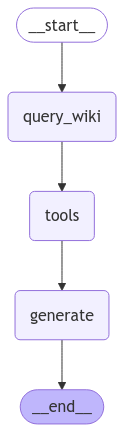

In [25]:
# set up the graph, including a conditional pass on the tools-based generation nodes

from langgraph.graph import END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph # we're using the MessageState to represent the different parts of our agent in a conversation
from langgraph.prebuilt import ToolNode

tools = ToolNode([wikipedia_tool]) # define the tools as a node

tool_graph_builder = StateGraph(MessagesState)

tool_graph_builder.add_node(generate)
tool_graph_builder.add_node(query_wiki)
tool_graph_builder.add_node(tools)

tool_graph_builder.set_entry_point("query_wiki")
tool_graph_builder.add_edge("query_wiki", "tools")
tool_graph_builder.add_edge("tools", "generate")
tool_graph_builder.add_edge("generate", END)

# add memory for prolongued converstations. For now, saving it in memory is sufficient
memory = MemorySaver()
tool_graph = tool_graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "test_thread"}}

display(Image(tool_graph.get_graph().draw_mermaid_png())) # show our graph architecture

In [49]:
wiki_retrieve("public sphere")

Query: public sphere
Articles found: ['Public sphere', 'The Structural Transformation of the Public Sphere', 'Public sphere pedagogy', 'Public domain', 'European public sphere', 'Private sphere', 'Separate spheres', 'Public', 'Refeudalization', 'Intellectual']
Structured model output failed. Using free form fallback option.
Relevant articles: [' Title: Public']
Getting full articles...
Retrieving relevant passages from the articles...


('Source: Title\nContent: == Post-nominal letters ==\nMembers of legislatures often have post-nominal letters expressing this:\n\nMember of Congress MC\nMember of Parliament MP\nMember of the European Parliament MEP\nMember of the Scottish Parliament MSP\nMember of the Scottish Youth Parliament MSYP\nMember of the Youth Parliament MYP\nMember of Provincial Parliament MPP\nMember of the National Assembly MNA\nMember of the House of Keys MHK\nSpeaker of the House of Keys SHK\nMember of the Legislative Council MLC\nMember of the Legislative Assembly MLA\nMember of the House of Representatives Rep.\nMember of the House of Assembly MHA\n\nSource: Title\nContent: Private, and many equivalent ranks depending on regiment.\nSergeant (from which come Sergeant at Mace and Sergeant at Arms).\n\nSource: Title\nContent: === Honorary titles ===\nMahatma\nOknha\nPandit\nSant\nSheikh\nSwami\nUstad\n\n\n=== Rulers ===\n\nChancellor (from which come Lord Chancellor and Vice-Chancellor)\n"Dear Leader" and

In [42]:
query = "public sphere"

summaries = summary_retriever.invoke(query)

articles = "\n\n".join(
        (f"Title: {doc.metadata["title"]}\n" f"Summary: {doc.metadata["summary"]}")
        for doc in summaries
        )

prompt = grading_prompt.invoke({"question": query, "articles": articles})

structured_llm = reasoning_llm.with_structured_output(relevant_articles)
relevant = structured_llm.invoke(prompt)

In [43]:
relevant

relevant_articles(titles=['Public sphere', 'The Structural Transformation of the Public Sphere', 'Public sphere pedagogy', 'Public domain', 'European public sphere', 'Private sphere', 'Separate spheres', 'Public', 'Refeudalization', 'Intellectual'])

In [41]:
reasoning_llm.invoke(prompt)

AIMessage(content='Public sphere; Public domain; European public sphere; Private sphere; Separate spheres; Public', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-01-29T17:09:30.5763137Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5139706200, 'load_duration': 1964444700, 'prompt_eval_count': 1775, 'prompt_eval_duration': 2586000000, 'eval_count': 18, 'eval_duration': 586000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-5d349adb-d74d-4892-a6ad-b3ab8b19ed72-0', usage_metadata={'input_tokens': 1775, 'output_tokens': 18, 'total_tokens': 1793})

In [22]:
input_message = "What is the public sphere?" 

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the public sphere?
================================== Ai Message ==================================
Tool Calls:
  WikpiediaRetriever (7a836fbb-cb6d-4fc4-b4a9-08048cc845e2)
 Call ID: 7a836fbb-cb6d-4fc4-b4a9-08048cc845e2
  Args:
    query: public sphere
Query: public sphere
Articles found: ['Public sphere', 'The Structural Transformation of the Public Sphere', 'Public sphere pedagogy', 'Public domain', 'European public sphere', 'Private sphere', 'Separate spheres', 'Public', 'Refeudalization', 'Intellectual']
None of the articles were deemed relevant.
================================= Tool Message =================================
Name: WikpiediaRetriever

["No relevant articles found.", []]
================================== Ai Message ==================================

I don't know. The retrieved context doesn't contain any relevant information on this topic.


In [17]:
input_message = "Does Rawls have anything to say about that?" 

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Does Rawls have anything to say about that?
================================== Ai Message ==================================
Tool Calls:
  WikpiediaRetriever (c98e8c68-3835-4c47-92bf-d2d26d868fb7)
 Call ID: c98e8c68-3835-4c47-92bf-d2d26d868fb7
  Args:
    query: John Rawls and public sphere
Query: John Rawls and public sphere
Articles found: ['Public reason', 'Jürgen Habermas', 'Public interest', 'The Public and Its Problems', 'Secularism', 'Political ethics', 'Social Justice in the Liberal State', 'Neoclassical liberalism', 'Anarchy, State, and Utopia', 'United States Air Force Symbol']
None of the articles were deemed relevant.
================================= Tool Message =================================
Name: WikpiediaRetriever

["No relevant articles found.", []]
================================== Ai Message ==================================

John Rawls' work on justice and the social contract doe

Note that the model tends to hallucinate / use its stock knowledge when the retriever does not return any relevant documents!

to do:
- figure out a way to use full documents, and come up with some way to make the whole document searchable in splits in order to fit the relevant passages into the context window (potentially after identifying relevant documents based on their summary)
- implement the wikipedia tool into a graph with routing
- build grading agent to decide whether or not to call the wikipedia AFTER the literature retriever, in case the passages retrieved were not helpful